# Experiment analysis

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 13)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
%matplotlib inline

In [199]:
df = pd.read_table('results.tsv', sep='\t')
print("Successful: {}\nFailed: {}".format(len(df[df['result.success'] == True]), len(df[df['result.success'] == False])))

print("Filtering failed experiments.")
df = df[df['result.success'] == True]

Successful: 472
Failed: 0
Filtering failed experiments.


In [151]:
def get_varying_columns(df, prefix=None):
    out_cols = []
    filtered_cols = df.columns
    if prefix is not None:
        filtered_cols = filter(lambda x: x.startswith(prefix), filtered_cols)
    for col in filtered_cols:
        if df[col].unique().shape[0] > 1:
            out_cols.append(col)
    return out_cols

def get_too_varying_columns(df, prefix=None, threshold=0.95):
    out_cols = []
    filtered_cols = df.columns
    if prefix is not None:
        filtered_cols = filter(lambda x: x.startswith(prefix), cols)
    for col in filtered_cols:
        uniq_vals = df[col].unique().shape[0]
        if uniq_vals > threshold * len(df):
            out_cols.append(col)
    return out_cols

In [190]:
feat_uniq_col = get_varying_columns(df, 'feat.')
result_uniq_col = get_varying_columns(df, 'result.')
model_uniq_col = get_varying_columns(df, 'model.')
non_monoton = get_varying_columns(df)
uninteresting_columns = filter(lambda x: x not in non_monoton, df.columns)
ignore_cols = [
    'result.train_loss', 'result.test_loss', 'result.timestamp', 'result.running_time',
]
result_uniq_col = [col for col in result_uniq_col if col not in ignore_cols]
interesting_columns = result_uniq_col + feat_uniq_col + model_uniq_col

## Unique feature combinations

In [191]:
df[feature_col].drop_duplicates()

,feat.use_padding,feat.sample_per_class,feat.include_smaller_ngrams,feat.N
0,True,10000.0,False,2.0
72,True,10000.0,False,1.0
204,True,30000.0,False,1.0
336,False,30000.0,False,6.0
402,True,30000.0,False,2.0
432,True,30000.0,True,2.0


### Number of experiments per combination

In [161]:
df.groupby(feature_col).count()['model.nb_epoch'].to_frame()

model.nb_epoch
feat.use_padding feat.sample_per_class feat.include_smaller_ngrams feat.N                
False            30000.0               False                       6.0                 66
True             10000.0               False                       1.0                132
                                                                   2.0                 72
                 30000.0               False                       1.0                132
                                                                   2.0                 30
                                       True                        2.0                 40

## Maximum test accuracy by feature combination

,result.test_acc,feat.use_padding,feat.sample_per_class,feat.include_smaller_ngrams,feat.N,model.nb_epoch,model.batch_size,model.input_dim,model.layers
359,0.819917,False,30000.0,False,6.0,30.0,2000.0,14036.0,"(40, 40)"
198,0.945750,True,10000.0,False,1.0,100.0,50.0,396.0,"(40, 40)"
39,0.966000,True,10000.0,False,2.0,50.0,500.0,3604.0,"(40, 40)"
325,0.973417,True,30000.0,False,1.0,90.0,100.0,481.0,"(100, 40)"
429,0.979500,True,30000.0,False,2.0,900.0,3000.0,5029.0,"(40, 40)"
453,0.985333,True,30000.0,True,2.0,300.0,500.0,5510.0,"(40, 40)"


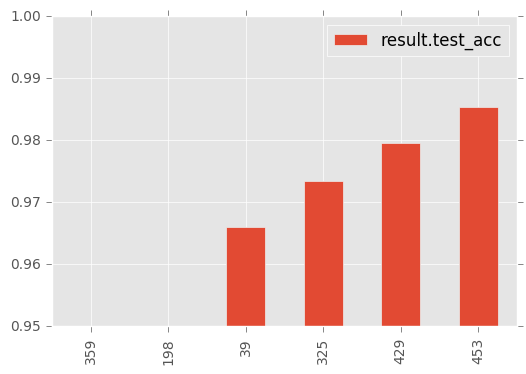

In [186]:
max_rows = df.iloc[df.groupby(feature_col).idxmax()['result.test_acc'].astype(int)]
max_rows.plot(y='result.test_acc', kind='bar', ylim=(0.95, 1))
max_rows[['result.test_acc'] + feat_uniq_col + model_uniq_col]

# The absolute best combination

In [274]:
best = df.iloc[df['result.test_acc'].idxmax()].to_frame().sort_index()
best

,453
feat.N,2
feat.data_path,/mnt/store/hlt/Language/Hungarian/Crawl/Web2/a...
feat.encoding,latin2
feat.include_smaller_ngrams,True
feat.last_char,6
feat.sample_per_class,30000
feat.tag_filter,"('NOUN', 'VERB')"
feat.use_padding,True
global.comment,include smaller ngrams - first experiments
global.nolog,False


In [275]:
df[df['feat.include_smaller_ngrams'] == True]['model.nb_epoch'].value_counts()

500.0    8
400.0    8
300.0    8
200.0    8
100.0    8
Name: model.nb_epoch, dtype: int64

In [311]:
def find_same_rows(df, lhs, include):
    filt = df
    for col in df.columns:
        if col in include:
            filt = filt[filt[col] == lhs[col].values[0]]
    return filt

In [312]:
filt = find_same_rows(df, best.transpose(), feat_uniq_col)

In [218]:
draw = False

if draw:
    f = df[df['feat.sample_per_class'] > 10000]
    batches = df['model.batch_size'].unique()

    for key, val in f.groupby(features):
        for nb in batches:
            filt = val[val['model.batch_size'] == nb]
            if len(filt) == 0:
                continue
            if filt['result.test_acc'].max() < 0.95:
                continue
            filt = filt.groupby('model.nb_epoch').mean()
            filt[filt['model.batch_size'] == nb].plot(y='result.test_acc', kind='bar',
                                                    ylim=(.9, 1), title="Epoch: {}, last_char: {} Sample: {} N: {}".format(
                    nb, key[0], key[5], key[-1]))